# Modelagem preditiva
_Machine Learning_

---

## Sum√°rio

1. **Importa√ß√£o de bibliotecas**
2. **Carregamento das bases**
    - 2.1. Carregamento dos dataframes
    - 2.2. Extra√ß√£o de amostra dos dataframes
3. **Prepara√ß√£o dos dados**
    - 3.1. Exibi√ß√£o dos metadados
    - 3.2. Prepara√ß√£o das bases de treino e teste
        - 3.2.1. An√°lise de cardinalidade
        - 3.2.2. Vari√°veis n√£o aplic√°veis √† modelagem
        - 3.2.3. Segmenta√ß√£o das bases **train** e **test**
        - 3.2.4. Transforma√ß√£o das features das bases **train** e **test**
4. **Modelagem preditiva**
    - 4.1. Treinamento de N modelos de classifica√ß√£o
    - 4.2. Avalia√ß√£o dos modelos de classifica√ß√£o
    - 4.3. Avalia√ß√£o do melhor modelo escolhido
5. **Tunagem dos hiperpar√¢metros do modelo**
    - 5.1. Tunagem e defini√ß√£o dos melhores hiperpar√¢metros
    - 5.2. Avalia√ß√£o do modelo com os melhores hiperpar√¢metros
    - 5.3. Avalia√ß√£o do modelo com a altera√ß√£o de thresholds
6. **An√°lise e desempenho do modelo com N vari√°veis**
    - 6.1. Visualiza√ß√£o das N vari√°veis mais importantes
    - 6.2. Avalia√ß√£o do modelo com N vari√°veis mais importantes

<br>

---

<br>

## 1. Importa√ß√£o de bibliotecas

In [1]:
# Importa√ß√£o de pacotes e defini√ß√£o de par√¢metros globais

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
import optuna

from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from optuna.samplers import TPESampler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, f1_score, auc, roc_curve, roc_auc_score, 
                             confusion_matrix, precision_recall_curve, precision_score, 
                             classification_report, recall_score, average_precision_score,
                             confusion_matrix, ConfusionMatrixDisplay)


In [2]:
# Configura√ß√µes para exibi√ß√£o de dados no Jupyter Notebook

# Configurar para exibir todas as colunas do Dataframe
pd.set_option('display.max_columns', None)

# Configurar para exibir o conte√∫do completo das colunas
pd.set_option('display.max_colwidth', None)

# Configurar a supress√£o de mensagens de aviso durante a execu√ß√£o
warnings.filterwarnings('ignore')

# Configurar o estilo do Seaborn
sns.set_theme(style='whitegrid')

## 2. Carregamento das bases

### 2.1. Carregamento dos dataframes

In [3]:
# Efetuando a limpeza de mem√≥ria antes do carregamento dos dados

print(f'\nQuantidade de objetos removidos da mem√≥ria: {gc.collect()}')


Quantidade de objetos removidos da mem√≥ria: 0


In [4]:
# Caminho base
base_path = Path('dados/dados_transformados_parquet/')

# Mapeamento nome_variavel: nome_arquivo
files = {
    'df_train': 'df_train.parquet',
    'df_val': 'df_val.parquet',
    'df_test': 'df_test.parquet'
}

# Carrega os DataFrames no dicion√°rio
temp_dfs = {}
for var_name, file_name in files.items():
    try:
        temp_dfs[var_name] = pd.read_parquet(base_path / file_name)
    except Exception as e:
        print(f'Erro ao carregar {file_name}: {e}')

# Atribui √†s vari√°veis explicitamente
df_train_full, df_val_full, df_test_full = [temp_dfs[name] for name in ['df_train', 'df_val', 'df_test']]


In [5]:
# Exibindo da volumetria dos dados

print('\nVOLUMETRIA')
for name, df in temp_dfs.items():
    print(f'\n{name}')
    print('-' * 45)
    print(f'Quantidade de linhas (registros):  {df.shape[0]:,}')
    print(f'Quantidade de colunas (vari√°veis): {df.shape[1]:,}')



VOLUMETRIA

df_train
---------------------------------------------
Quantidade de linhas (registros):  3,566,068
Quantidade de colunas (vari√°veis): 157

df_val
---------------------------------------------
Quantidade de linhas (registros):  891,518
Quantidade de colunas (vari√°veis): 157

df_test
---------------------------------------------
Quantidade de linhas (registros):  2,194,300
Quantidade de colunas (vari√°veis): 157


### 2.2. Extra√ß√£o de amostra dos dataframes

In [6]:
# Fun√ß√£o para gera√ß√£o de uma amostra estratificada de um DataFrame

def stratified_sample_classification(df, y_col, frac):
    '''
    Retorna uma amostra estratificada de um DataFrame com base na vari√°vel-alvo 
    mantendo a propor√ß√£o original das classes.

    :param df: DataFrame
        DataFrame contendo as features e a vari√°vel-alvo.
    :param y_col: str
        Nome da coluna correspondente √† vari√°vel-alvo (classe).
    :param frac: float
        Fra√ß√£o (entre 0 e 1) de registros a serem amostrados.
    :return: DataFrame
        Subconjunto amostrado do DataFrame original.
    '''
    sample_df, _ = train_test_split(
        df,
        train_size=frac,
        stratify=df[y_col],
        random_state=42
    )

    return sample_df

In [7]:
# Nome da vari√°vel-alvo
y_col = 'is_fraud'

# Fra√ß√£o desejada
frac = 0.25

# Gerando amostras estratificadas e uma amostra aleat√≥ria
df_train = stratified_sample_classification(df_train_full, y_col, frac)
df_val   = stratified_sample_classification(df_val_full, y_col, frac)
df_test  = df_test_full.sample(frac=frac, random_state=42)

In [8]:
# Comparativo dos tamanhos dos DataFrames originais e amostrados
print(f'       Original ‚Üí Amostra')
print(f'Train: {len(df_train_full)}  ‚Üí {len(df_train)}')
print(f'Val:   {len(df_val_full)}   ‚Üí {len(df_val)}')
print(f'Test:  {len(df_test_full)}  ‚Üí {len(df_test)}')

       Original ‚Üí Amostra
Train: 3566068  ‚Üí 891517
Val:   891518   ‚Üí 222879
Test:  2194300  ‚Üí 548575


## 3. Prepara√ß√£o dos dados

### 3.1. Exibi√ß√£o dos metadados

In [9]:
# Fun√ß√£o para gera√ß√£o de um dataframe de metadados

def generate_metadata(dataframe):
    '''
    Gera um DataFrame contendo metadados das colunas do DataFrame fornecido.

    :param dataframe: DataFrame
        DataFrame para o qual os metadados ser√£o gerados.
    :return: DataFrame
        DataFrame contendo os metadados.
    '''
    metadata = pd.DataFrame({
        'Vari√°vel': dataframe.columns,
        'Tipo': dataframe.dtypes,
        'Qtde de nulos': dataframe.isnull().sum(),
        '% de nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
        'Cardinalidade': dataframe.nunique(),
    }).sort_values(by='Qtde de nulos', ascending=False).reset_index(drop=True)

    return metadata


In [10]:
# Exibe todas as linhas temporariamente

with pd.option_context('display.max_rows', None):
    display(generate_metadata(df_train))


Vari√°vel            Tipo  Qtde de nulos  % de nulos  \
0                           errors          object         877190       98.39   
1                 card_std_last_1h         float64         832500       93.38   
2                 card_std_last_2h         float64         814406       91.35   
3               client_std_last_1h         float64         802096       89.97   
4                 card_std_last_4h         float64         784767       88.03   
5               client_std_last_2h         float64         765354       85.85   
6                 card_std_last_8h         float64         737993       82.78   
7               client_std_last_4h         float64         707408       79.35   
8                card_std_last_12h         float64         702581       78.81   
9               client_std_last_8h         float64         620469       69.60   
10               card_std_last_24h         float64         568980       63.82   
11             client_std_last_12h         float64         558763       62.68   
12               card_std_last_48h         float64         397399       44.58   
13             client_std_last_24h         float64         348467       39.09   
14               card_std_last_72h         float64         291081       32.65   
15             client_std_last_48h         float64         157743       17.69   
16                             zip         float64         110867       12.44   
17                card_std_last_7d         float64         108050       12.12   
18                  merchant_state          object         104842       11.76   
19             client_std_last_72h         float64          79057        8.87   
20               card_std_last_14d         float64          31253        3.51   
21               card_std_last_21d         float64          12528        1.41   
22              client_std_last_7d         float64           8997        1.01   
23               card_std_last_30d         float64           5236        0.59   
24               card_std_last_45d         float64           2149        0.24   
25             client_std_last_14d         float64            838        0.09   
26             client_std_last_21d         float64            381        0.04   
27             client_std_last_30d         float64            334        0.04   
28             client_std_last_45d         float64            321        0.04   
29                      birth_year           int32              0        0.00   
30                  retirement_age           int32              0        0.00   
31                     current_age           int32              0        0.00   
32                       id_client           int32              0        0.00   
33                card_on_dark_web          object              0        0.00   
34           year_pin_last_changed           int32              0        0.00   
35                  acct_open_date  datetime64[ns]              0        0.00   
36                    credit_limit           int64              0        0.00   
37                num_cards_issued           int32              0        0.00   
38                        has_chip          object              0        0.00   
39                             cvv           int32              0        0.00   
40                         expires           int32              0        0.00   
41                     card_number           int64              0        0.00   
42                       card_type          object              0        0.00   
43                      card_brand          object              0        0.00   
44                  client_id_card           int32              0        0.00   
45                         id_card           int32              0        0.00   
46                             mcc           int32              0        0.00   
47                     merchant_id           int32              0        0.00   
48                   merchant_city          object      

### 3.2. Prepara√ß√£o das bases de treino e teste

#### 3.2.1. An√°lise de cardinalidade

In [11]:
# Listando vari√°veis com determinado valor de cardinalidade

def list_low_cardinality_columns(dataframe, threshold=2):
    '''
    Lista os nomes das colunas de um DataFrame com cardinalidade inferior a um valor dado.

    :param dataframe: pd.DataFrame
        DataFrame a ser analisado.
    :param threshold: int
        Valor de corte para cardinalidade. Default √© 2.
    :return: list
        Lista com os nomes das colunas cuja cardinalidade √© menor que o threshold.
    '''
    return [col for col in dataframe.columns if dataframe[col].nunique(dropna=False) < threshold]


In [12]:
print('df_train - vari√°veis com baixa cardinalidade:\n', list_low_cardinality_columns(df_train))
print('\ndf_val - vari√°veis com baixa cardinalidade:\n', list_low_cardinality_columns(df_val))
print('\ndf_test - vari√°veis com baixa cardinalidade:\n', list_low_cardinality_columns(df_test))

df_train - vari√°veis com baixa cardinalidade:
 ['card_on_dark_web', 'flag_risky_chip_use', 'flag_no_chip_darkweb']

df_val - vari√°veis com baixa cardinalidade:
 ['card_on_dark_web', 'flag_risky_chip_use', 'flag_no_chip_darkweb']

df_test - vari√°veis com baixa cardinalidade:
 ['card_on_dark_web', 'transaction_id', 'is_fraud', 'flag_risky_chip_use', 'flag_no_chip_darkweb']


#### 3.2.2. Vari√°veis n√£o aplic√°veis √† modelagem

In [13]:
# Lista as features de um DataFrame que cont√™m o termo 'id' no nome.

def list_columns_with_id(dataframe, case_sensitive=False):
    '''
    Lista os nomes das colunas de um DataFrame que cont√™m 'id' no nome.

    :param dataframe: pd.DataFrame
        DataFrame a ser analisado.
    :param case_sensitive: bool
        Se True, diferencia mai√∫sculas de min√∫sculas. Default √© False.
    :return: list
        Lista com os nomes das colunas que cont√™m 'id'.
    '''
    if case_sensitive:
        return [col for col in dataframe.columns if 'id' in col]
    else:
        return [col for col in dataframe.columns if 'id' in col.lower()]


In [14]:
print('df_train - vari√°veis com termo "id":\n', list_columns_with_id(df_train))
print('\ndf_val - vari√°veis com termo "id":\n', list_columns_with_id(df_val))
print('\ndf_test - vari√°veis com termo "id":\n', list_columns_with_id(df_test))

df_train - vari√°veis com termo "id":
 ['id', 'client_id', 'card_id', 'merchant_id', 'id_card', 'client_id_card', 'id_client', 'transaction_id', 'merchant_id_is_new']

df_val - vari√°veis com termo "id":
 ['id', 'client_id', 'card_id', 'merchant_id', 'id_card', 'client_id_card', 'id_client', 'transaction_id', 'merchant_id_is_new']

df_test - vari√°veis com termo "id":
 ['id', 'client_id', 'card_id', 'merchant_id', 'id_card', 'client_id_card', 'id_client', 'transaction_id', 'merchant_id_is_new']


In [15]:
# Criando conjunto de vari√°veis que ser√£o removidas dos DataFrames

vars_to_remove = ['zip', 'date', 'expires', 'acct_open_date']
vars_to_remove = vars_to_remove + ['id', 'client_id', 'card_id', 'merchant_id', 'id_card', 'client_id_card', 
                  'id_client', 'transaction_id', 'merchant_id_is_new','card_on_dark_web', 
                  'flag_risky_chip_use', 'flag_no_chip_darkweb']

#### 3.2.3. Segmenta√ß√£o das bases **train** e **test**

In [16]:
# Separando as vari√°veis preditivas e a vari√°vel preditora (alvo)

features = df_train.columns.drop('is_fraud')
features = features.drop(vars_to_remove, errors='ignore')
target = 'is_fraud'

In [17]:
# Separando as vari√°veis num√©ricas e categ√≥ricas

numerical_features = df_train[features].select_dtypes(exclude=[object, 'category']).columns
categorical_features = df_train[features].select_dtypes(include=[object, 'category']).columns

In [18]:
# Converter todas as colunas categ√≥ricas para string

df_train[categorical_features] = df_train[categorical_features].astype(str)
df_val[categorical_features] = df_val[categorical_features].astype(str)
df_test[categorical_features] = df_test[categorical_features].astype(str)

In [19]:
# Removendo as vari√°veis dos DataFrames de treino e teste

X_train = df_train[features]
y_train = df_train[target]

X_test = df_val[features]
y_test = df_val[target]

In [20]:
# Convertendo a vari√°vel alvo para num√©rica

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

#### 3.2.4. Transforma√ß√£o das features das bases **train** e **test**

In [21]:
# Criando o pipeline para as vari√°veis num√©ricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Criando o pipeline para as vari√°veis categ√≥ricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder())
])

In [22]:
# Criando o pipeline de pr√©-processamento que aplica transforma√ß√µes

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('num', num_pipeline, numerical_features)
])
preprocessor = Pipeline(steps=[('preprocessor', preprocessor)])

In [23]:
# Verificando os shapes antes da transforma√ß√£o

print(f'Shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape: X_test:  {X_test.shape},  y_test: {y_test.shape}')

Shape: X_train: (891517, 140), y_train: (891517,)
Shape: X_test:  (222879, 140),  y_test: (222879,)


In [24]:
# Aplicando o pr√©-processamento nos conjuntos de treino e teste

X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

In [25]:
# Verificando os shapes ap√≥s transforma√ß√£o

print(f'Shape de X_train ap√≥s transforma√ß√£o: {X_train_processed.shape}')
print(f'Shape de X_test ap√≥s transforma√ß√£o:  {X_test_processed.shape}')

Shape de X_train ap√≥s transforma√ß√£o: (891517, 140)
Shape de X_test ap√≥s transforma√ß√£o:  (222879, 140)


## 4. Modelagem preditiva

### 4.1. Treinamento de N modelos de classifica√ß√£o

In [26]:
# Algoritmos de classifica√ß√£o a serem testados com o m√≠nimo de par√¢metros

algorithms = {
    'DecisionTreeClassifier': DecisionTreeClassifier(class_weight='balanced', criterion='gini', random_state=42),
    'LogisticRegression': LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    'XGBClassifier': XGBClassifier(eval_metric='logloss', verbosity=0, random_state=42, n_jobs=-1),
    'LGBMClassifier': LGBMClassifier(is_unbalance=True, verbosity=-1, random_state=42, n_jobs=-1)
}  

In [27]:
def calculate_metrics(models, X_train, y_train, X_test, y_test, preprocessor):
    '''
    Calcula e exibe as m√©tricas de desempenho dos modelos fornecidos.

    :param models: dict
        Dicion√°rio contendo os modelos a serem avaliados.
    :param X_train: DataFrame
        Conjunto de dados de treino.
    :param y_train: np.ndarray
        R√≥tulos do conjunto de dados de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste.
    :param y_test: np.ndarray
        R√≥tulos do conjunto de dados de teste.
    :param preprocessor: Pipeline
        Pipeline de pr√©-processamento a ser aplicado aos dados.
    '''
    rows = []

    for name, model in models.items():
        
        # Cria um pipeline que inclui o pr√©-processamento e o modelo
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        # Registra o tempo de in√≠cio de treinamento
        start_time = time.time()
        
        # Treina o modelo e faz previs√µes
        pipeline.fit(X_train, y_train)
        
        # Registra o tempo de dura√ß√£o do treinamento
        elapsed_time = time.time() - start_time
        
        # Itera sobre os conjuntos de treino e teste para calcular as m√©tricas
        for dataset_name, X, y_true in [('Treino', X_train, y_train), ('Teste', X_test, y_test)]:
            # Faz previs√µes no conjunto atual
            y_pred = pipeline.predict(X)
            y_proba = pipeline.predict_proba(X)[:, 1]
            
            # M√©trica KS: compara distribui√ß√µes das probabilidades para as duas classes
            ks_stat = ks_2samp(y_proba[y_true == 1], y_proba[y_true == 0]).statistic

            # M√©trica Gini: 2 * AUC - 1
            auc = roc_auc_score(y_true, y_proba)
            gini = 2 * auc - 1
            
            # Calcula as m√©tricas de desempenho
            rows.append({
                'Algoritmo': name,# if dataset_name == 'Treino' else '',
                'Conjunto': dataset_name,
                'Acur√°cia': accuracy_score(y_true, y_pred),
                'Precis√£o': precision_score(y_true, y_pred, zero_division=0),
                'Recall': recall_score(y_true, y_pred),
                'F1-Score': f1_score(y_true, y_pred),
                'ROC AUC': auc, #roc_auc_score(y_true, y_proba),
                'PR AUC': average_precision_score(y_true, y_proba),
                'KS': ks_stat,
                'Gini': gini,
                'Tempo (s)': elapsed_time if dataset_name == 'Treino' else ''
            })
                     
    # Cria o DataFrame final com os resultados
    results_df = pd.DataFrame(rows)
    
    return results_df

In [28]:
# Avaliando os modelos
results_df = calculate_metrics(algorithms, X_train, y_train, X_test, y_test, preprocessor)

# Exibindo os resultados
results_df

Algoritmo Conjunto  Acur√°cia  Precis√£o    Recall  F1-Score  \
0  DecisionTreeClassifier   Treino  1.000000  1.000000  1.000000  1.000000   
1  DecisionTreeClassifier    Teste  0.998273  0.393574  0.295181  0.337349   
2      LogisticRegression   Treino  0.947915  0.026296  0.942771  0.051166   
3      LogisticRegression    Teste  0.942484  0.023361  0.921687  0.045566   
4  RandomForestClassifier   Treino  0.999998  1.000000  0.998494  0.999246   
5  RandomForestClassifier    Teste  0.998560  1.000000  0.033133  0.064140   
6           XGBClassifier   Treino  0.999962  0.996166  0.978163  0.987082   
7           XGBClassifier    Teste  0.998291  0.437975  0.521084  0.475928   
8          LGBMClassifier   Treino  0.958633  0.034026  0.977410  0.065763   
9          LGBMClassifier    Teste  0.947622  0.022964  0.822289  0.044681   

    ROC AUC    PR AUC        KS      Gini   Tempo (s)  
0  1.000000  1.000000  1.000000  1.000000  103.977382  
1  0.647251  0.117225  0.294502  0.294502              
2  0.984497  0.302400  0.895845  0.968994   61.600852  
3  0.971917  0.234536  0.866058  0.943835              
4  1.000000  1.000000  1.000000  1.000000  159.846387  
5  0.922112  0.459434  0.822852  0.844224              
6  0.993238  0.985948  0.985198  0.986477   29.130529  
7  0.955144  0.371101  0.847158  0.910289              
8  0.967499  0.033292  0.936016  0.934999   22.630799  
9  0.884867  0.019148  0.770098  0.769734

### 4.2. Avalia√ß√£o dos modelos de classifica√ß√£o

In [29]:
def plot_metrics(results_df):
    '''
    Plota as m√©tricas de desempenho dos modelos em subplots.

    :param results_df: DataFrame
        DataFrame contendo as colunas ['Algoritmo', 'Conjunto', <m√©tricas...>] com os resultados
        de avalia√ß√£o dos modelos para treino e teste.
    '''

    # Verifica colunas obrigat√≥rias
    expected_columns = {'Algoritmo', 'Conjunto'}
    if not expected_columns.issubset(results_df.columns):
        raise ValueError(f'O DataFrame deve conter as colunas: {expected_columns}')

    # Define as m√©tricas a serem plotadas
    metric_columns = ['Acur√°cia', 'Precis√£o', 'Recall', 'F1-Score', 'ROC AUC', 'PR AUC', 'KS', 'Gini', 'Tempo (s)']
    for metric in metric_columns:
        if metric not in results_df.columns:
            raise ValueError(f'M√©trica {metric} n√£o foi encontrada no DataFrame.')

    # Figura
    fig, axes = plt.subplots(5, 2, figsize=(16, 18))
    fig.suptitle('M√©tricas de Desempenho dos Modelos', fontsize=18, y=0.93, fontweight='bold')

    # Gera√ß√£o dos gr√°ficos
    for ax, metric in zip(axes.flatten(), metric_columns):
        sns.barplot(
            data=results_df,
            x='Algoritmo',
            y=metric,
            hue='Conjunto',
            palette=['#61b3ef', '#f39e53'],
            dodge=True,
            ax=ax,
        )
        ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=10)
        ax.set_title(metric, fontsize=14)
        ax.set_xlabel('')
        ax.set_ylabel('')
        if metric == 'Tempo (s)':
            max_tempo = results_df[metric].max()
            ax.set_ylim(0, max_tempo * 1.1)  # D√° um pouco de espa√ßo acima do maior valor
        else:
            ax.set_ylim(0, 1.1)  # Ajusta escala padr√£o para m√©tricas entre 0 e 1
        ax.legend_.remove()

        # Adiciona os valores nas barras
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', label_type='edge', fontsize=10)
            
    # Remove o √∫ltimo eixo (o 10¬∫ subplot)
    axes.flatten()[-1].set_visible(False)

    # Legenda global no topo
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, title='Conjunto', loc='upper center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, 0.99))

    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    plt.show()

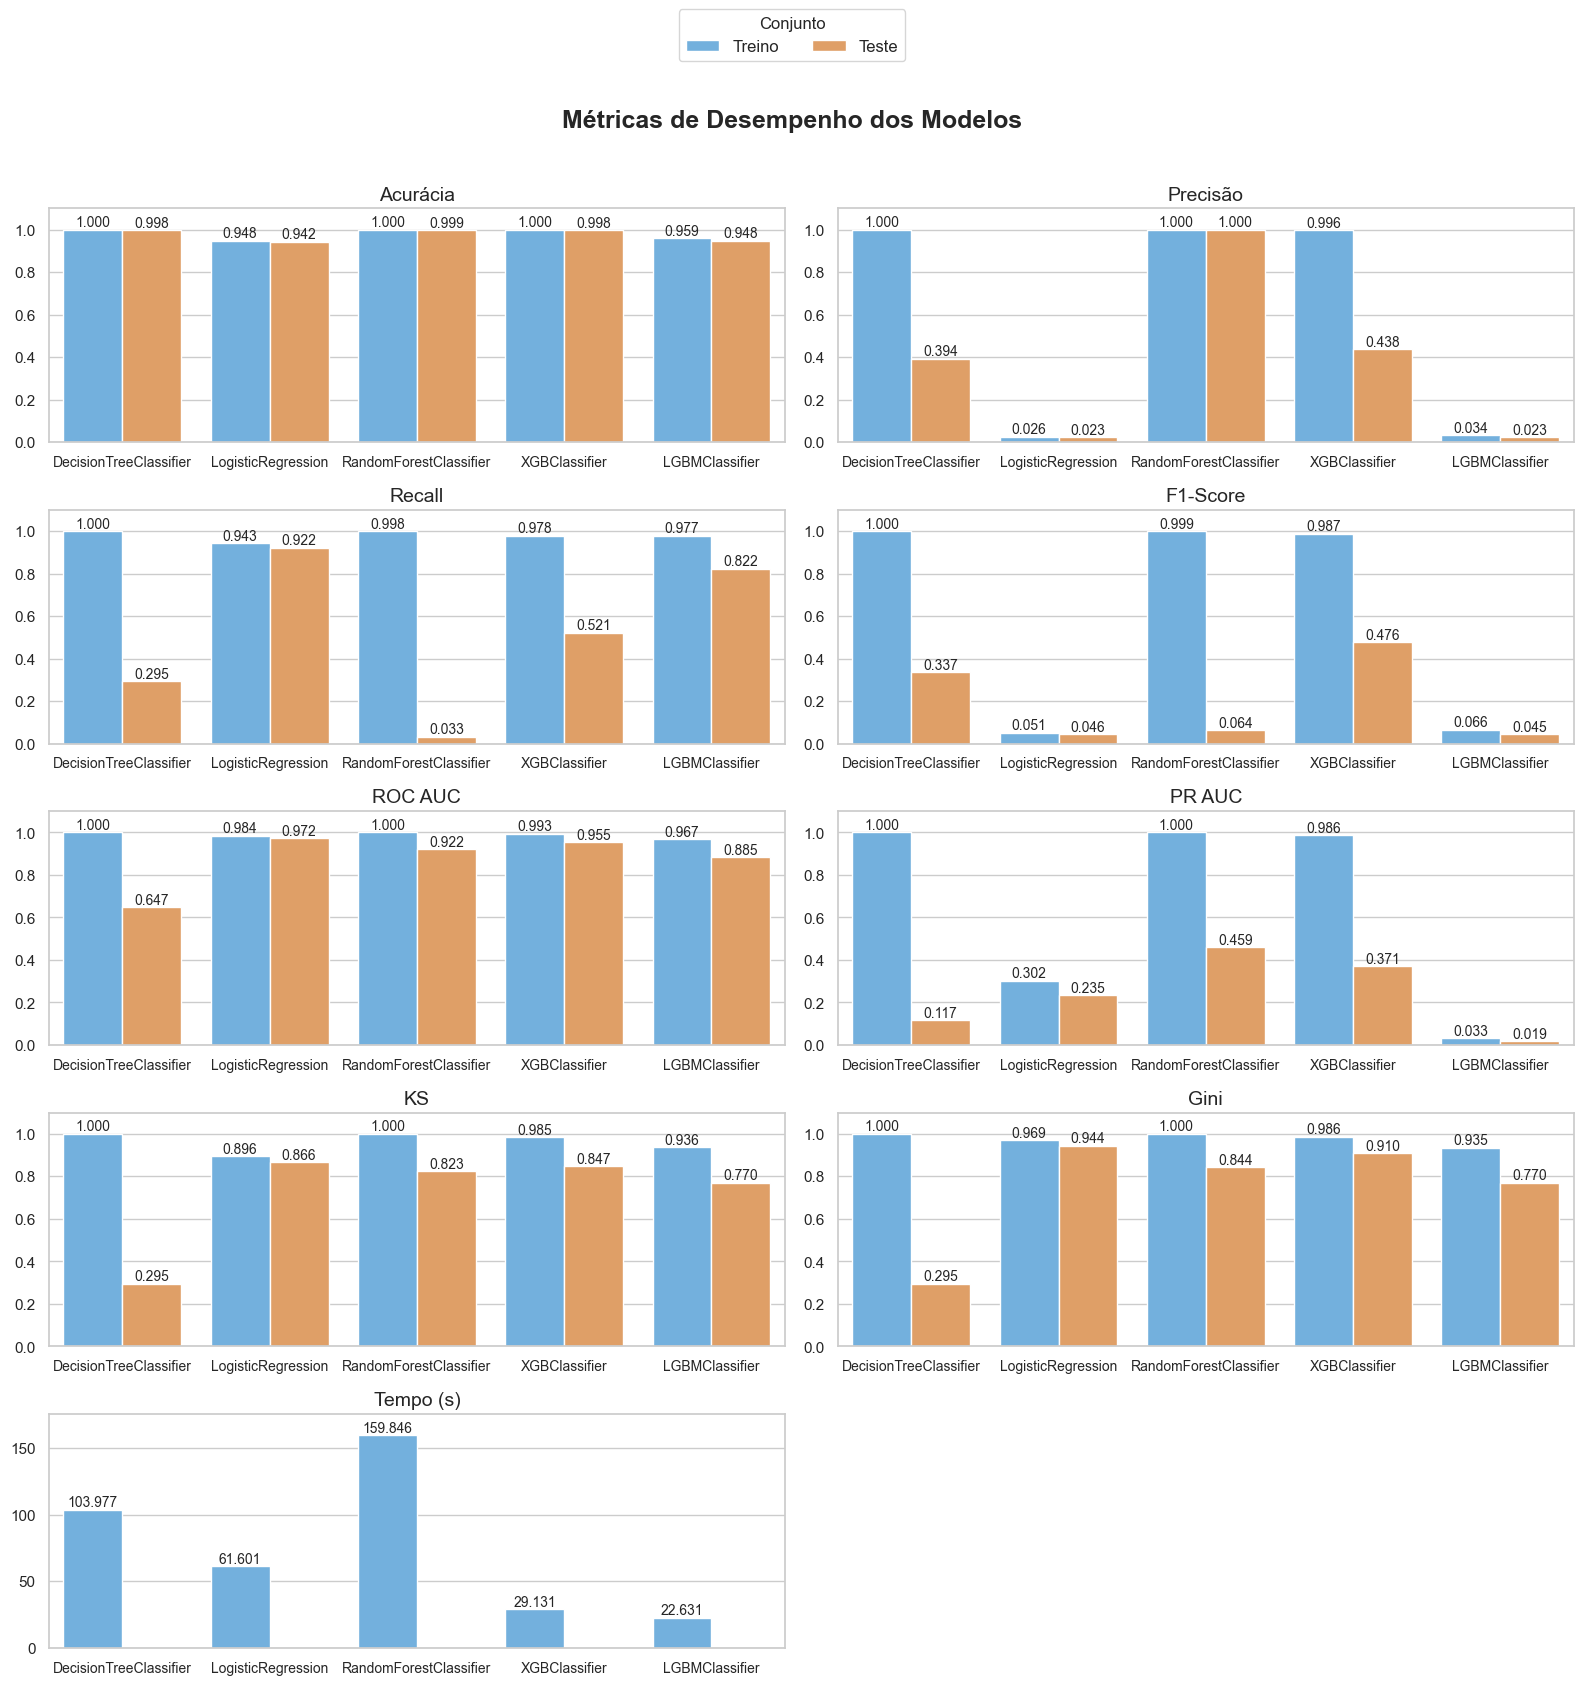

In [30]:
# Garante que 'Tempo (s)' seja num√©rico
results_df['Tempo (s)'] = pd.to_numeric(results_df['Tempo (s)'], errors='coerce')

# Plota as m√©tricas de desempenho dos modelos
plot_metrics(results_df)

O modelo aplicado ao problema de detec√ß√£o de fraudes em transa√ß√µes financeiras precisa ser capaz de diferenciar com precis√£o transa√ß√µes leg√≠timas de fraudulentas. Para isso, foram testados cinco algoritmos de classifica√ß√£o supervisionada, todos com parametriza√ß√£o m√≠nima e com foco em tratar a natureza desbalanceada dos dados, onde a classe _"fraude"_ √© rara e representa uma pequena fra√ß√£o das transa√ß√µes. Para medir a performance dos modelos, foram utilizadas 9 m√©tricas de avalia√ß√£o, sendo que algumas merecem destaque especial, como **Precis√£o**, **Recall**, **F1-Score** e **PR AUC**, por refletirem melhor o desempenho em cen√°rios de classes desbalanceadas.

- **Acur√°cia (Accuracy)**: Mede a propor√ß√£o total de acertos entre todas as previs√µes (tanto fraudes quanto n√£o fraudes). Apesar de todos os modelos apresentarem acur√°cia superior a 94%, essa m√©trica n√£o √© confi√°vel neste cen√°rio, pois um modelo que simplesmente preve _"n√£o fraude"_ para todas as transa√ß√µes j√° teria uma acur√°cia alta, sendo assim n√£o detectaria nenhuma fraude real.

- **Precis√£o (Precision)**: Esta m√©trica mede quantas das transa√ß√µes classificadas como _"fraude"_ realmente s√£o fraudes. Em termos pr√°ticos, quanto maior a precis√£o, menor o risco de falsos positivos, ou seja, de bloquear transa√ß√µes leg√≠timas. O modelo XGBoost foi o √∫nico a apresentar boa precis√£o sem ind√≠cios claros de overfitting ou underfitting.

- **Recall (Sensibilidade)**: Indica a propor√ß√£o de fraudes reais que o modelo conseguiu identificar. Quanto maior o _recall_, maior a capacidade do modelo de detectar fraudes verdadeiras, sendo portanto uma das m√©tricas mais relevantes neste contexto de neg√≥cio. Modelos como Regress√£o Log√≠stica, XGBoost e LightGBM tiveram bom desempenho nessa m√©trica.

- **F1-Score**: Combina precis√£o e recall numa m√©dia harm√¥nica, equilibrando os dois aspectos. √ötil para avaliar se o modelo est√° tanto identificando fraudes quanto sendo preciso nas detec√ß√µes. O modelo XGBoost apresentou o _F1-Score_ mais consistente, indicando equil√≠brio entre as duas m√©tricas.

- **ROC AUC (√Årea sob a Curva ROC)**: Mede a capacidade do modelo em separar classes, ou seja, prever corretamente fraudes e n√£o fraudes. Embora seja uma m√©trica comum, pode ser enganosa em casos com classes muito desbalanceadas, pois considera a performance sobre a classe majorit√°ria. Por isso, n√£o √© a melhor escolha isoladamente neste cen√°rio de forte desbalanceamento de classes.

- **PR AUC (√Årea sob a Curva Precis√£o vs. Recall)**: Essa √© a m√©trica mais recomendada para problemas de fraudes, pois avalia a rela√ß√£o entre as m√©tricas _precis√£o_ e _recall_ com maior sensibilidade ao desbalanceamento de classes. O XGBoost se destacou novamente, se comparado com os demais modelos, enquanto o RandomForest mostrou overfitting, com √≥timo desempenho em treino, mas pior em teste.

- **KS (Kolmogorov-Smirnov)**: Mede a dist√¢ncia m√°xima entre as distribui√ß√µes de pontua√ß√£o das classes positiva (fraude) e negativa (n√£o fraude). Quanto maior o valor de KS, melhor o modelo em separar as duas classes. Modelos como Regress√£o Log√≠stica, XGBoost e LightGBM apresentaram valores consistentes e semelhantes nos conjuntos de treino e teste.

- **Gini**: Derivada da ROC AUC, a m√©trica Gini mede o poder de discrimina√ß√£o do modelo (quanto maior, melhor). Muito usada em contextos banc√°rios e regulat√≥rios. Modelos com Gini acima de 0.6 j√° s√£o considerados bons para esse tipo de tarefa. Partindo dessa premissa apenas Regress√£o Log√≠stica, XGBoost e LightGBM apresentaram bom desempenho.

- **Tempo (s)**: Refere-se ao tempo necess√°rio para treinar e aplicar o modelo. Em aplica√ß√µes reais, esse tempo precisa ser r√°pido o suficiente para garantir fluidez nas valida√ß√µes de transa√ß√µes. Nesse quesito os modelos XGBoost e LightGBM apresentaram os melhores tempos de execu√ß√£o, sendo vi√°veis para aplica√ß√µes em produ√ß√£o.

Ao combinar essas m√©tricas, foi poss√≠vel identificar que o modelo como **XGBoost** teve o melhor equil√≠brio entre performance e robustez. Al√©m disso, a an√°lise das m√©tricas, principalmente **Precis√£o**, **Recall**, **F1-Score** e **PR AUC**, permitiu avaliar corretamente a efetividade dos modelos no contexto do problema, focando na detec√ß√£o eficaz de fraudes reais, com controle de falsos positivos.

### 4.3. Avalia√ß√£o do melhor modelo escolhido

In [31]:
def plot_metrics(model, X_train, y_train, X_test, y_test, features, top_n_features=15):
    '''
    Gera visualiza√ß√µes de avalia√ß√£o de desempenho de um modelo de classifica√ß√£o bin√°ria.

    :param model: estimator
        Estimador do scikit-learn previamente treinado.
    :param X_train: DataFrame
        Conjunto de dados de treino.
    :param y_train: np.ndarray
        R√≥tulos do conjunto de dados de treino.
    :param X_test: DataFrame
        Conjunto de dados de teste.
    :param y_test: np.ndarray
        R√≥tulos do conjunto de dados de teste.
    :param features: list or np.ndarray
        Lista ou array contendo os nomes das vari√°veis preditoras.
    :param top_n_features: int, default=10
        N√∫mero de vari√°veis mais importantes a serem exibidas.
    '''
    
    plt.figure(figsize=(16, 24))
    colors = ['#61b3ef', '#f39e53']
    cmap_custom = LinearSegmentedColormap.from_list("custom_blues", ['#e8f4fd', '#61b3ef'])

    # --- 1. Distribui√ß√£o de Evento e N√£o Evento ---
    plt.subplot(5, 2, 1)
    event_rate = y_train.mean()
    values = [1 - event_rate, event_rate]
    labels = ['N√£o evento', 'Evento']

    ax = sns.barplot(y=labels, x=values, palette=colors)
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.2%}', (width, p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=10, fontweight='bold',
                    color='black', xytext=(5, 0), textcoords='offset points')
    plt.xlabel('\nPropor√ß√£o', fontsize=12)
    plt.title('Taxa de Evento/N√£o evento', fontsize=14, fontweight='bold')
    ax.set_xlim(0, max(values) + 0.1)
    sns.despine()
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # --- 2. Import√¢ncia das Vari√°veis ---
    plt.subplot(5, 2, 2)
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_).flatten()
        else:
            raise AttributeError('Modelo n√£o possui "feature_importances_" nem "coef_".')
        
        indices = np.argsort(importances)[::-1][:top_n_features]
        ax = sns.barplot(y=np.array(features)[indices], x=importances[indices], color=colors[0])
        plt.xlabel('\nImport√¢ncia', fontsize=12)
        plt.title('Import√¢ncia das vari√°veis', fontsize=14, fontweight='bold')
        sns.despine()
        plt.grid(axis='x', linestyle='--', alpha=0.7)
    except Exception as e:
        plt.text(0.5, 0.5, f'Erro ao calcular import√¢ncia:\n{e}', ha='center')
        plt.axis('off')

    # --- 3. Curva ROC-AUC ---
    plt.subplot(5, 2, 3)
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]):
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})', color=colors[i], linewidth=2)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1.2)
    plt.xlabel('\nTaxa de Falsos Positivos (FPR)', fontsize=10)
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)\n', fontsize=10)
    plt.title('Curva ROC-AUC', fontsize=12, fontweight='bold')
    plt.legend(loc='lower right', frameon=True, framealpha=0.9, edgecolor='gray')
    plt.grid(True, linestyle='--', alpha=0.3)
    sns.despine()

    # --- 4. Curva Precision-Recall ---
    plt.subplot(5, 2, 4)
    y_probs = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)
    ap_score = average_precision_score(y_test, y_probs)
    plt.plot(recall, precision, color=colors[1], lw=2, label=f'Precis√£o M√©dia (AP) = {ap_score:.2f}')
    plt.fill_between(recall, precision, alpha=0.1, color=colors[1])
    plt.title('Curva Precision-Recall', fontsize=14, fontweight='bold')
    plt.xlabel('\nRecall', fontsize=12)
    plt.ylabel('Precision\n', fontsize=12)
    plt.xlim(0, 1.0)
    plt.ylim(0, 1.05)
    plt.legend(loc='lower left', frameon=True, framealpha=0.9, edgecolor='gray')
    plt.grid(True, linestyle='--', alpha=0.3)
    sns.despine()

    # --- 5 e 6. Matrizes de Confus√£o ---
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], start=5):
        plt.subplot(5, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap_custom,
                    cbar_kws={'label': ''}, linewidths=0.5,
                    linecolor='gray', square=True)
        plt.xlabel('\nClasse Predita', fontsize=10)
        plt.ylabel('Classe Real\n', fontsize=10)
        plt.title(f'Matriz de Confus√£o - {label}', fontsize=12, fontweight='bold')
        plt.xticks(ticks=[0.5, 1.5], labels=['N√£o Evento', 'Evento'])
        plt.yticks(ticks=[0.5, 1.5], labels=['N√£o Evento', 'Evento'], rotation=0)

    # --- 7. KS e Gini ---
    metrics_data = []
    for dataset_name, X, y_true in [('Treino', X_train, y_train), ('Teste', X_test, y_test)]:
        y_proba = model.predict_proba(X)[:, 1]
        ks_stat = ks_2samp(y_proba[y_true == 1], y_proba[y_true == 0]).statistic
        auc_score = roc_auc_score(y_true, y_proba)
        gini = 2 * auc_score - 1
        metrics_data.extend([
            {'Dataset': dataset_name, 'M√©trica': 'KS', 'Valor': ks_stat},
            {'Dataset': dataset_name, 'M√©trica': 'Gini', 'Valor': gini}
        ])
    df_metrics = pd.DataFrame(metrics_data)

    plt.subplot(5, 2, 7)
    ax = sns.barplot(data=df_metrics, x='M√©trica', y='Valor', hue='Dataset', palette=colors)
    for p in ax.patches:
        valor = p.get_height()
        if valor == 0:
            continue  # pula valores nulos
        ax.annotate(f'{valor:.2f}', (p.get_x() + p.get_width() / 2, valor),
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
    plt.title('M√©tricas KS e Gini', fontsize=12, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Valor da M√©trica\n', fontsize=10)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.xticks([0, 1], ['KS', 'Gini'])  # Ajustando manualmente os r√≥tulos do eixo X
    sns.despine()
    
    # --- 8. Gr√°fico do Precision e Recall vs. Limiar ---
    plt.subplot(5, 2, 8)
    precisions, recalls, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(thresholds, precisions[:-1], label='Precision', color=colors[0], lw=2)
    plt.plot(thresholds, recalls[:-1], label='Recall', color=colors[1], lw=2)
    plt.title('Precision e Recall vs. Limiar de Decis√£o', fontsize=12, fontweight='bold')
    plt.xlabel('\nLimiar de Decis√£o')
    plt.ylabel('Valor da M√©trica\n')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    sns.despine()

    # --- 9. Distribui√ß√£o dos Scores por Classe (Treino) ---
    plt.subplot(5, 2, 9)    
    fraude_scores = model.predict_proba(X_train)[:, 1][y_train == 1]
    nao_fraude_scores = model.predict_proba(X_train)[:, 1][y_train == 0]
    sns.kdeplot(nao_fraude_scores, label='N√£o Fraude', color=colors[0], shade=True)
    sns.kdeplot(fraude_scores, label='Fraude', color=colors[1], shade=True)
    plt.title('Distribui√ß√£o dos Scores por Classe - Treino', fontsize=12, fontweight='bold')
    plt.xlabel('Score de Fraude')
    plt.ylabel('Densidade')
    plt.legend(loc='upper center')
    plt.grid(True, linestyle='--', alpha=0.3)
    sns.despine()

    # --- 10. Distribui√ß√£o dos Scores por Classe (Teste) ---
    plt.subplot(5, 2, 10)    
    fraude_scores = model.predict_proba(X_test)[:, 1][y_test == 1]
    nao_fraude_scores = model.predict_proba(X_test)[:, 1][y_test == 0]
    sns.kdeplot(nao_fraude_scores, label='N√£o Fraude', color=colors[0], shade=True)
    sns.kdeplot(fraude_scores, label='Fraude', color=colors[1], shade=True)
    plt.title('Distribui√ß√£o dos Scores por Classe - Teste', fontsize=12, fontweight='bold')
    plt.xlabel('Score de Fraude')
    plt.ylabel('Densidade')
    plt.legend(loc='upper center')
    plt.grid(True, linestyle='--', alpha=0.3)
    sns.despine()

    # --- Layout Final ---
    plt.suptitle('An√°lise de Desempenho do Modelo de Classifica√ß√£o',
                fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()


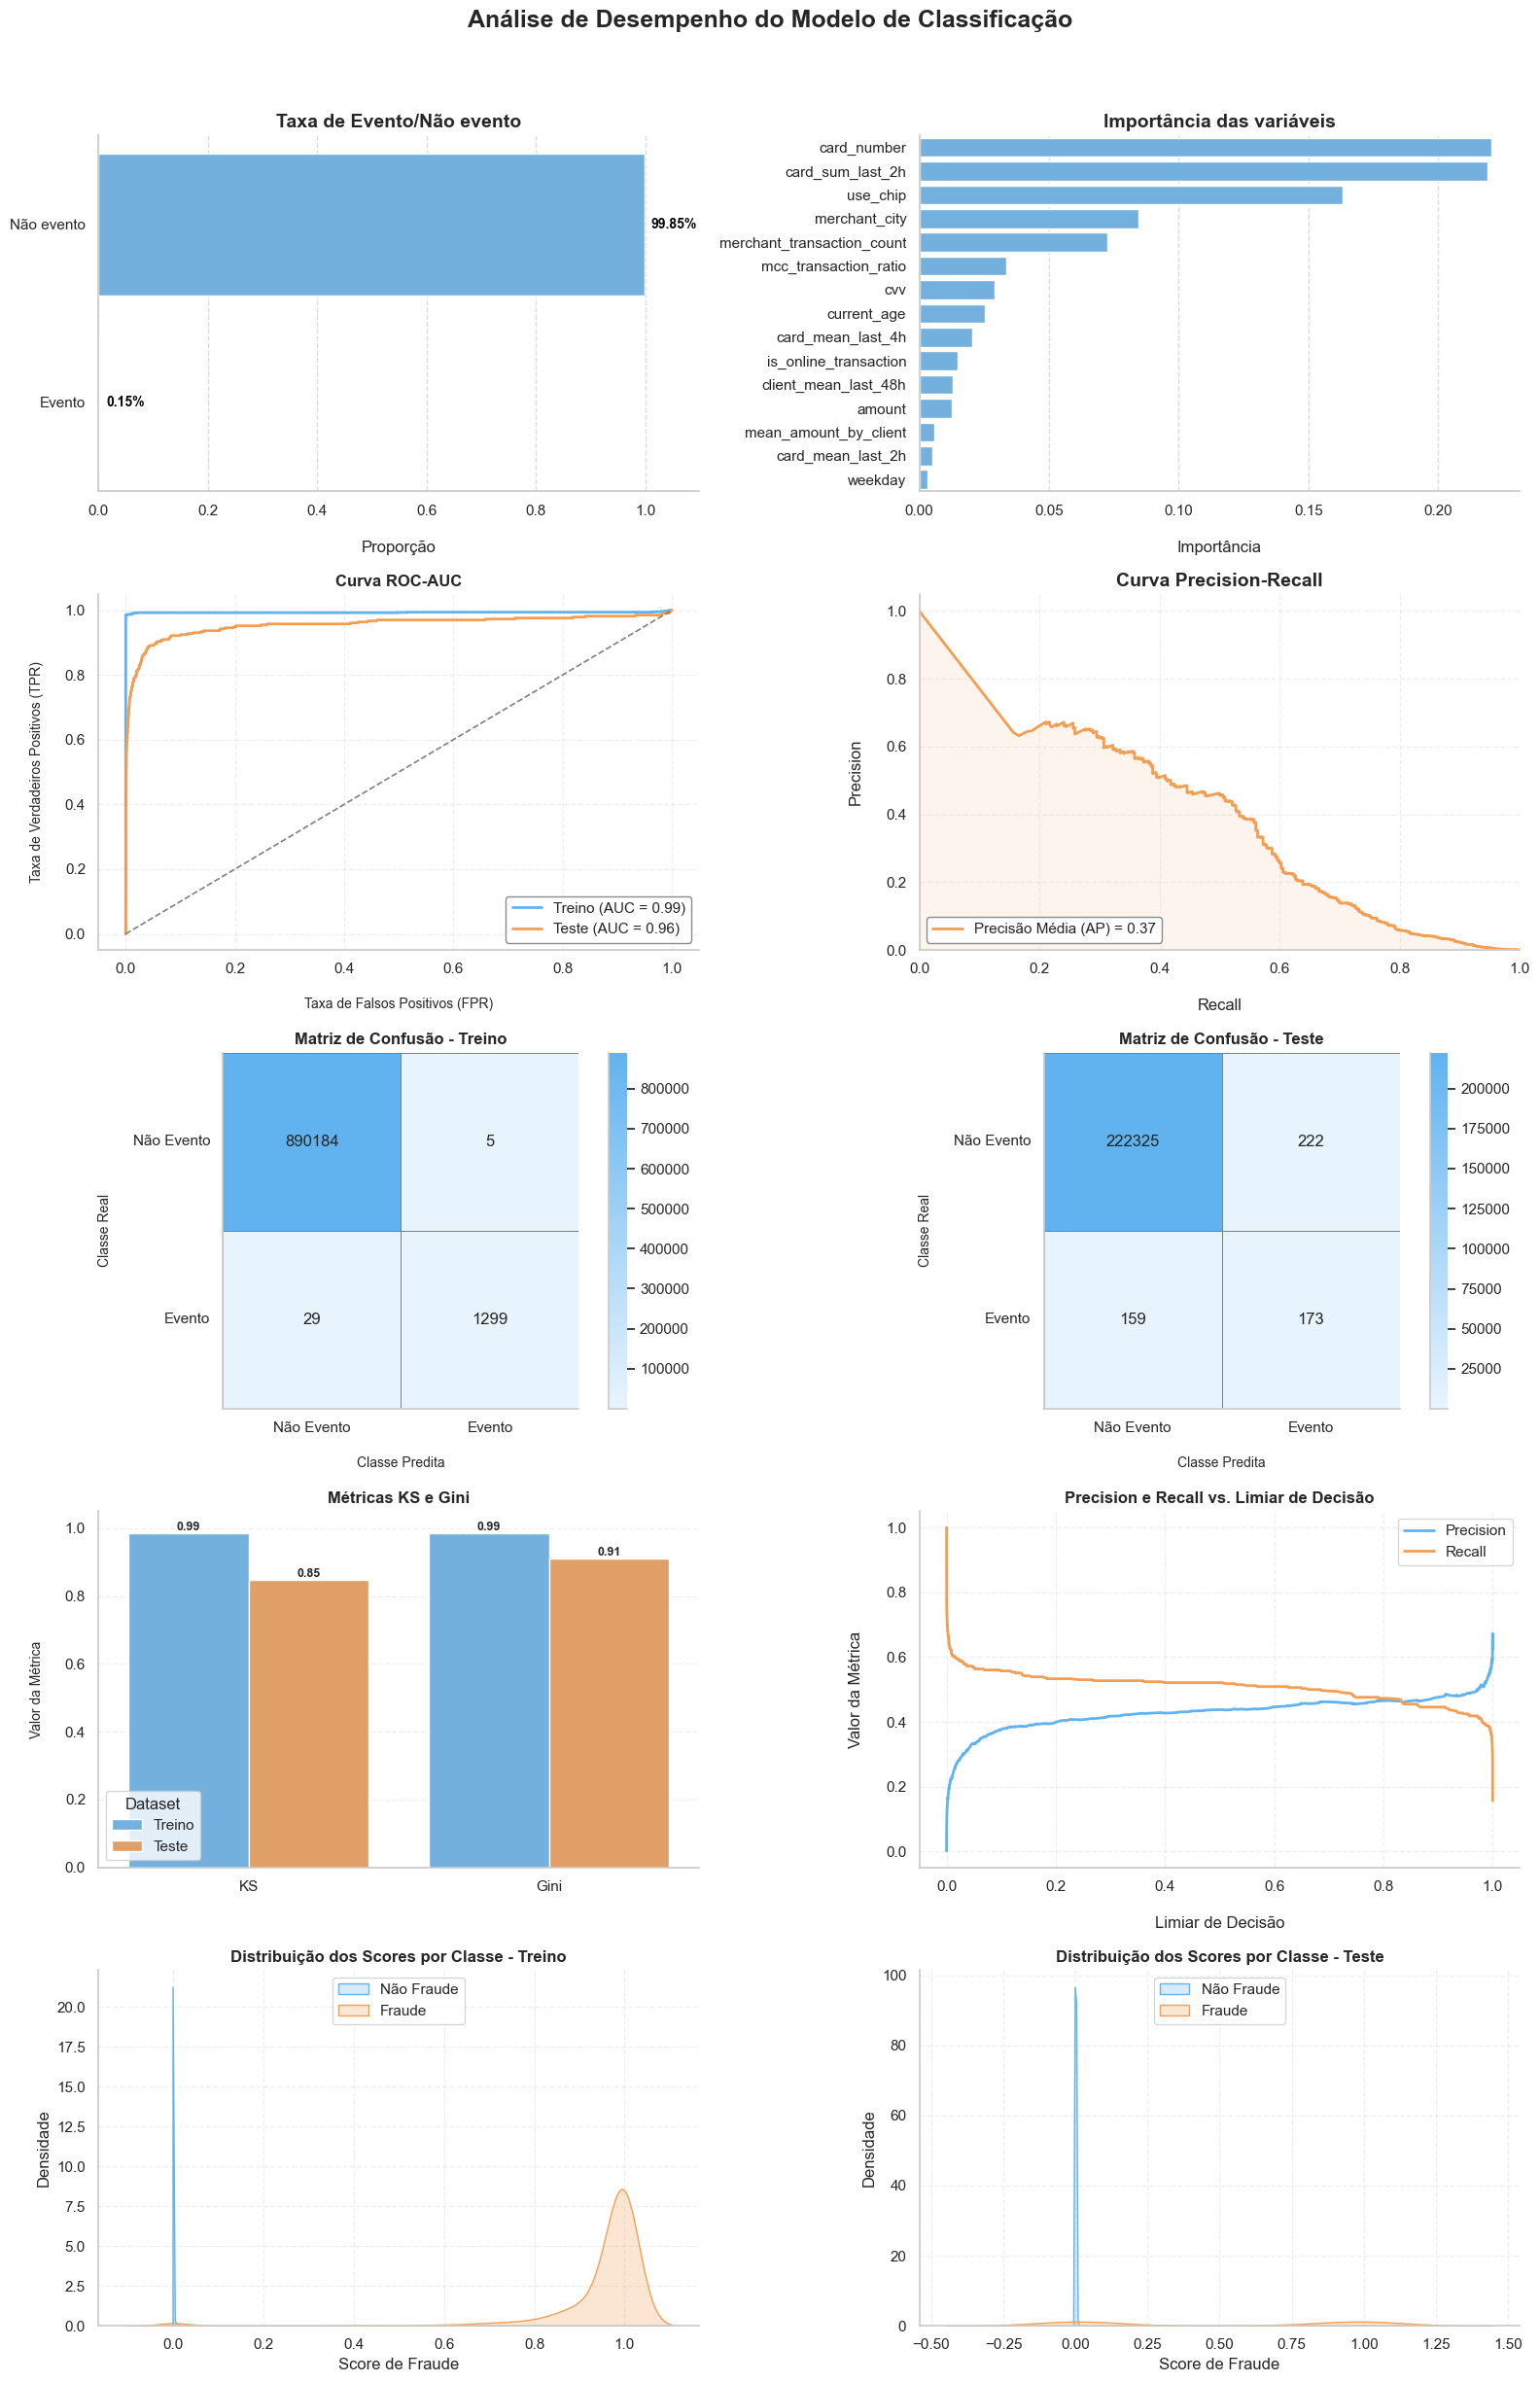

In [32]:
# Obt√©m os nomes das features
features = X_train.columns

# Treinando o melhor modelo com os dados de treino
best_algorithm = XGBClassifier(eval_metric='logloss', verbosity=0, random_state=42, n_jobs=-1)

# Treinando o modelo com os dados j√° pr√©-processados
best_algorithm.fit(X_train_processed,y_train)

# Plota as m√©tricas de desempenho do melhor modelo
plot_metrics(best_algorithm, X_train_processed, y_train, X_test_processed, y_test, features)

O modelo **XGBoost** foi selecionado para constru√ß√£o do modelo preditivo de detec√ß√£o de fraudes com base no seu desempenho equilibrado entre diversas m√©tricas, robustez e tempo de execu√ß√£o. Abaixo um breve an√°lise gr√°fica do conjunto de dados e de mais m√©tricas de desempenho do modelo:

- **Taxa de evento/N√£o evento**: O conjunto de dados apresenta forte desbalanceamento, com aproximadamente **0,15% de eventos (fraudes)** e **99,85% de n√£o eventos (transa√ß√µes leg√≠timas)**. Esse desbalanceamento torna o problema desafiador e refor√ßa a necessidade de utilizar m√©tricas apropriadas, como Precis√£o (Precision), Recall, F1-Score e PR AUC.

- **Import√¢ncia das vari√°veis**: Foram exibidas as 15 vari√°veis mais relevantes, indicando que o modelo est√° captando padr√µes comportamentais relevantes na atividade dos cart√µes, o que pode auxiliar na explica√ß√£o e confiabilidade do modelo no contexto de neg√≥cios.

- **Curva ROC-AUC**: A curva ROC mostra uma boa separa√ß√£o entre classes. A AUC foi de **0.99 no treino** e **0.96 no teste**, indicando boa capacidade do modelo em distinguir transa√ß√µes fraudulentas de leg√≠timas. Apesar disso, a ROC-AUC sozinha n√£o √© suficiente neste contexto de conjunto de dados desbalanceados.

- **Curva Precision-Recall**: Mostra a rela√ß√£o entre a capacidade do modelo de identificar fraudes (recall) e o n√≠vel de confian√ßa nessas previs√µes (precis√£o). A √°rea sob essa curva, Precis√£o M√©dia (AP), foi de 0.37, o que representa um razo√°vel desempenho considerando um problema com eventos t√£o raros e um modelo com parametriza√ß√£o m√≠nima.

- **Matrizes de Confus√£o (Treino e Teste)**: Ao analisar o conjunto de treino o modelo apresentou um bom desempenho indicando 5 falsos positivos (transa√ß√µes leg√≠timas marcadas como fraude) e 29 falsos negativos, entretanto no conjundo de teste foram apontados **222 falsos positivos** e **159 falsos negativos**, indicando que o modelo necessita de ajustes para melhora sua capacidade de identificar fraudes.

- **M√©tricas KS e Gini**: A estat√≠stica KS (Kolmogorov-Smirnov) de 0.99 (treino) e 0.85 (teste) indicam boa separa√ß√£o entre fraudes e n√£o fraudes. O √≠ndice Gini de 0.99 (treino) e 0.91 (teste) para valores acima de 0.6 s√£o considerados muito bons em aplica√ß√µes financeiras.

- **Precision e Recall vs. Limiar de Decis√£o**: Esse gr√°fico ajuda a entender o impacto de ajustar o limiar de decis√£o (por padr√£o √© 0.5), √† medida que o limiar diminui, o recall aumenta (mais fraudes s√£o detectadas), mas a precis√£o cai (mais falsos positivos).

- **Distribui√ß√£o dos Scores por Classe**: O modelo no conjunto de treino atribuiu scores baixos √†s transa√ß√µes leg√≠timas (alta densidade pr√≥xima de 0) e scores altos √†s transa√ß√µes fraudulentas (concentradas pr√≥ximas de 1), entretanto no conjunto teste h√° incid√™ncia de fraudes tanto em scores baixos quanto em altos. 

## 5. Tunagem dos hiperpar√¢metros do modelo

### 5.1. Tunagem e defini√ß√£o dos melhores hiperpar√¢metros

In [33]:
# Contagem de amostras negativas e positivas
n_negative = sum(y_train == 0)
n_positive = sum(y_train == 1)

# C√°lculo do peso de balanceamento entre classes
scale_pos_weight = n_negative / n_positive

print(f'Scale Pos Weight: {scale_pos_weight:.5f}')

Scale Pos Weight: 670.32304


In [34]:
def objective_xgboost(trial):
    '''
    Fun√ß√£o objetivo para otimiza√ß√£o de hiperpar√¢metros do XGBoost usando Optuna.
    
    :param trial: optuna.Trial
        Objeto que sugere valores para os hiperpar√¢metros do modelo durante o processo de otimiza√ß√£o.
        
    :return: float
        Retorna a m√©trica de avalia√ß√£o do modelo, que ser√° minimizada ou maximizada pelo Optuna.
    '''
        
    model = XGBClassifier(
        # N√∫mero de √°rvores (boosting rounds) no modelo, cada √°rvore corrige os erros da anterior
        n_estimators=trial.suggest_int('n_estimators', 400, 450),
        # Taxa de aprendizado que controla o impacto de cada √°rvore no resultado final
        learning_rate=trial.suggest_float('learning_rate', 0.045, 0.055, log=True), 
        # Profundidade m√°xima das √°rvores, controla a complexidade e o overfitting      
        max_depth=trial.suggest_int('max_depth', 8, 10),
        # Propor√ß√£o de amostras usadas por √°rvore, ajuda a evitar overfitting
        subsample=trial.suggest_float('subsample', 0.85, 0.95),
        # Propor√ß√£o de features usadas por √°rvore, reduz correla√ß√£o e overfitting
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.60, 0.65),
        # Ganho m√≠nimo necess√°rio para realizar uma divis√£o (split) em uma √°rvore
        gamma=trial.suggest_float('gamma', 1e-8, 1e-5, log=True),
        # Regulariza√ß√£o L1 (Lasso), penaliza a complexidade do modelo e reduz overfitting      
        reg_alpha=trial.suggest_float('reg_alpha', 1.0, 2.0, log=True),
        # Regulariza√ß√£o L2 (Ridge), penaliza grandes coeficientes e ajuda a generaliza√ß√£o
        reg_lambda=trial.suggest_float('reg_lambda', 6.5, 7.5, log=True),
        # Peso m√≠nimo de inst√¢ncias em uma folha, evita divis√µes com poucos dados
        min_child_weight=trial.suggest_int('min_child_weight', 4, 8),
        # Semente aleat√≥ria para garantir reprodutibilidade dos resultados
        random_state=42,
        # Ajusta o peso da classe minorit√°ria para lidar com desbalanceamento
        scale_pos_weight=scale_pos_weight,
        # Desativa avisos de deprecia√ß√£o sobre codifica√ß√£o autom√°tica de r√≥tulos
        use_label_encoder=False,
        # M√©trica usada para avaliar o modelo durante o treinamento
        eval_metric='logloss',
    )
    
    # Cria um pipeline que inclui o pr√©-processamento e o modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor), ('model', model)
    ])
    
    # Treina o modelo usando o pipeline
    pipeline.fit(X_train, y_train)
    
    # Fazer previs√µes no conjunto de teste
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Faz previs√µes no conjunto de teste e calcula as m√©tricas
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)

    # Armazenar m√©tricas no trial para posterior an√°lise
    trial.set_user_attr('precision', precision)
    trial.set_user_attr('recall', recall)
    trial.set_user_attr('f1', f1)
    trial.set_user_attr('roc_auc', roc_auc)
    trial.set_user_attr('pr_auc', pr_auc)
    
    return f1

In [35]:
# Cria o estudo Optuna com o sampler TPE
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))

# Otimiza o modelo com a fun√ß√£o objetivo
study.optimize(objective_xgboost, n_trials=50, n_jobs=-1, show_progress_bar=True, timeout=3600)

[I 2025-07-17 15:08:48,679] A new study created in memory with name: no-name-23d6b0b8-c070-46c1-953d-8356452b2ab7


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-17 15:18:11,408] Trial 3 finished with value: 0.659942363112392 and parameters: {'n_estimators': 408, 'learning_rate': 0.04930216001967923, 'max_depth': 8, 'subsample': 0.9129275848098023, 'colsample_bytree': 0.6100907802884534, 'gamma': 1.712314417328312e-08, 'reg_alpha': 1.120334395106249, 'reg_lambda': 7.3997501607055804, 'min_child_weight': 4}. Best is trial 3 with value: 0.659942363112392.
[I 2025-07-17 15:18:27,961] Trial 4 finished with value: 0.6425470332850941 and parameters: {'n_estimators': 422, 'learning_rate': 0.050950162876093226, 'max_depth': 8, 'subsample': 0.9014671304808413, 'colsample_bytree': 0.6099076814093001, 'gamma': 1.4098470481756226e-06, 'reg_alpha': 1.87939136250416, 'reg_lambda': 6.928283967121617, 'min_child_weight': 8}. Best is trial 3 with value: 0.659942363112392.
[I 2025-07-17 15:18:41,315] Trial 5 finished with value: 0.6540697674418605 and parameters: {'n_estimators': 432, 'learning_rate': 0.04865079015418147, 'max_depth': 8, 'subsample': 

In [36]:
# Acessando o melhor trial
best_trial = study.best_trial

# Exibindo os melhores hiperpar√¢metros
print('MELHORES HIPERPAR√ÇMETROS')
for key, value in best_trial.params.items():
    print(f'{key}: {value}')

# Exibindo as m√©tricas armazenadas com set_user_attr
print('\nM√âTRICAS DO MELHOR TRIAL')
for key, value in best_trial.user_attrs.items():
    print(f'{key}: {value:.5f}')

MELHORES HIPERPAR√ÇMETROS
n_estimators: 418
learning_rate: 0.04869604815853821
max_depth: 8
subsample: 0.9306444936464053
colsample_bytree: 0.606620670312981
gamma: 5.04326123536835e-08
reg_alpha: 1.1470232585289308
reg_lambda: 7.174742611391579
min_child_weight: 5

M√âTRICAS DO MELHOR TRIAL
precision: 0.63836
recall: 0.70181
f1: 0.66858
roc_auc: 0.99236
pr_auc: 0.72824


### 5.2. Avalia√ß√£o do modelo com os melhores hiperpar√¢metros

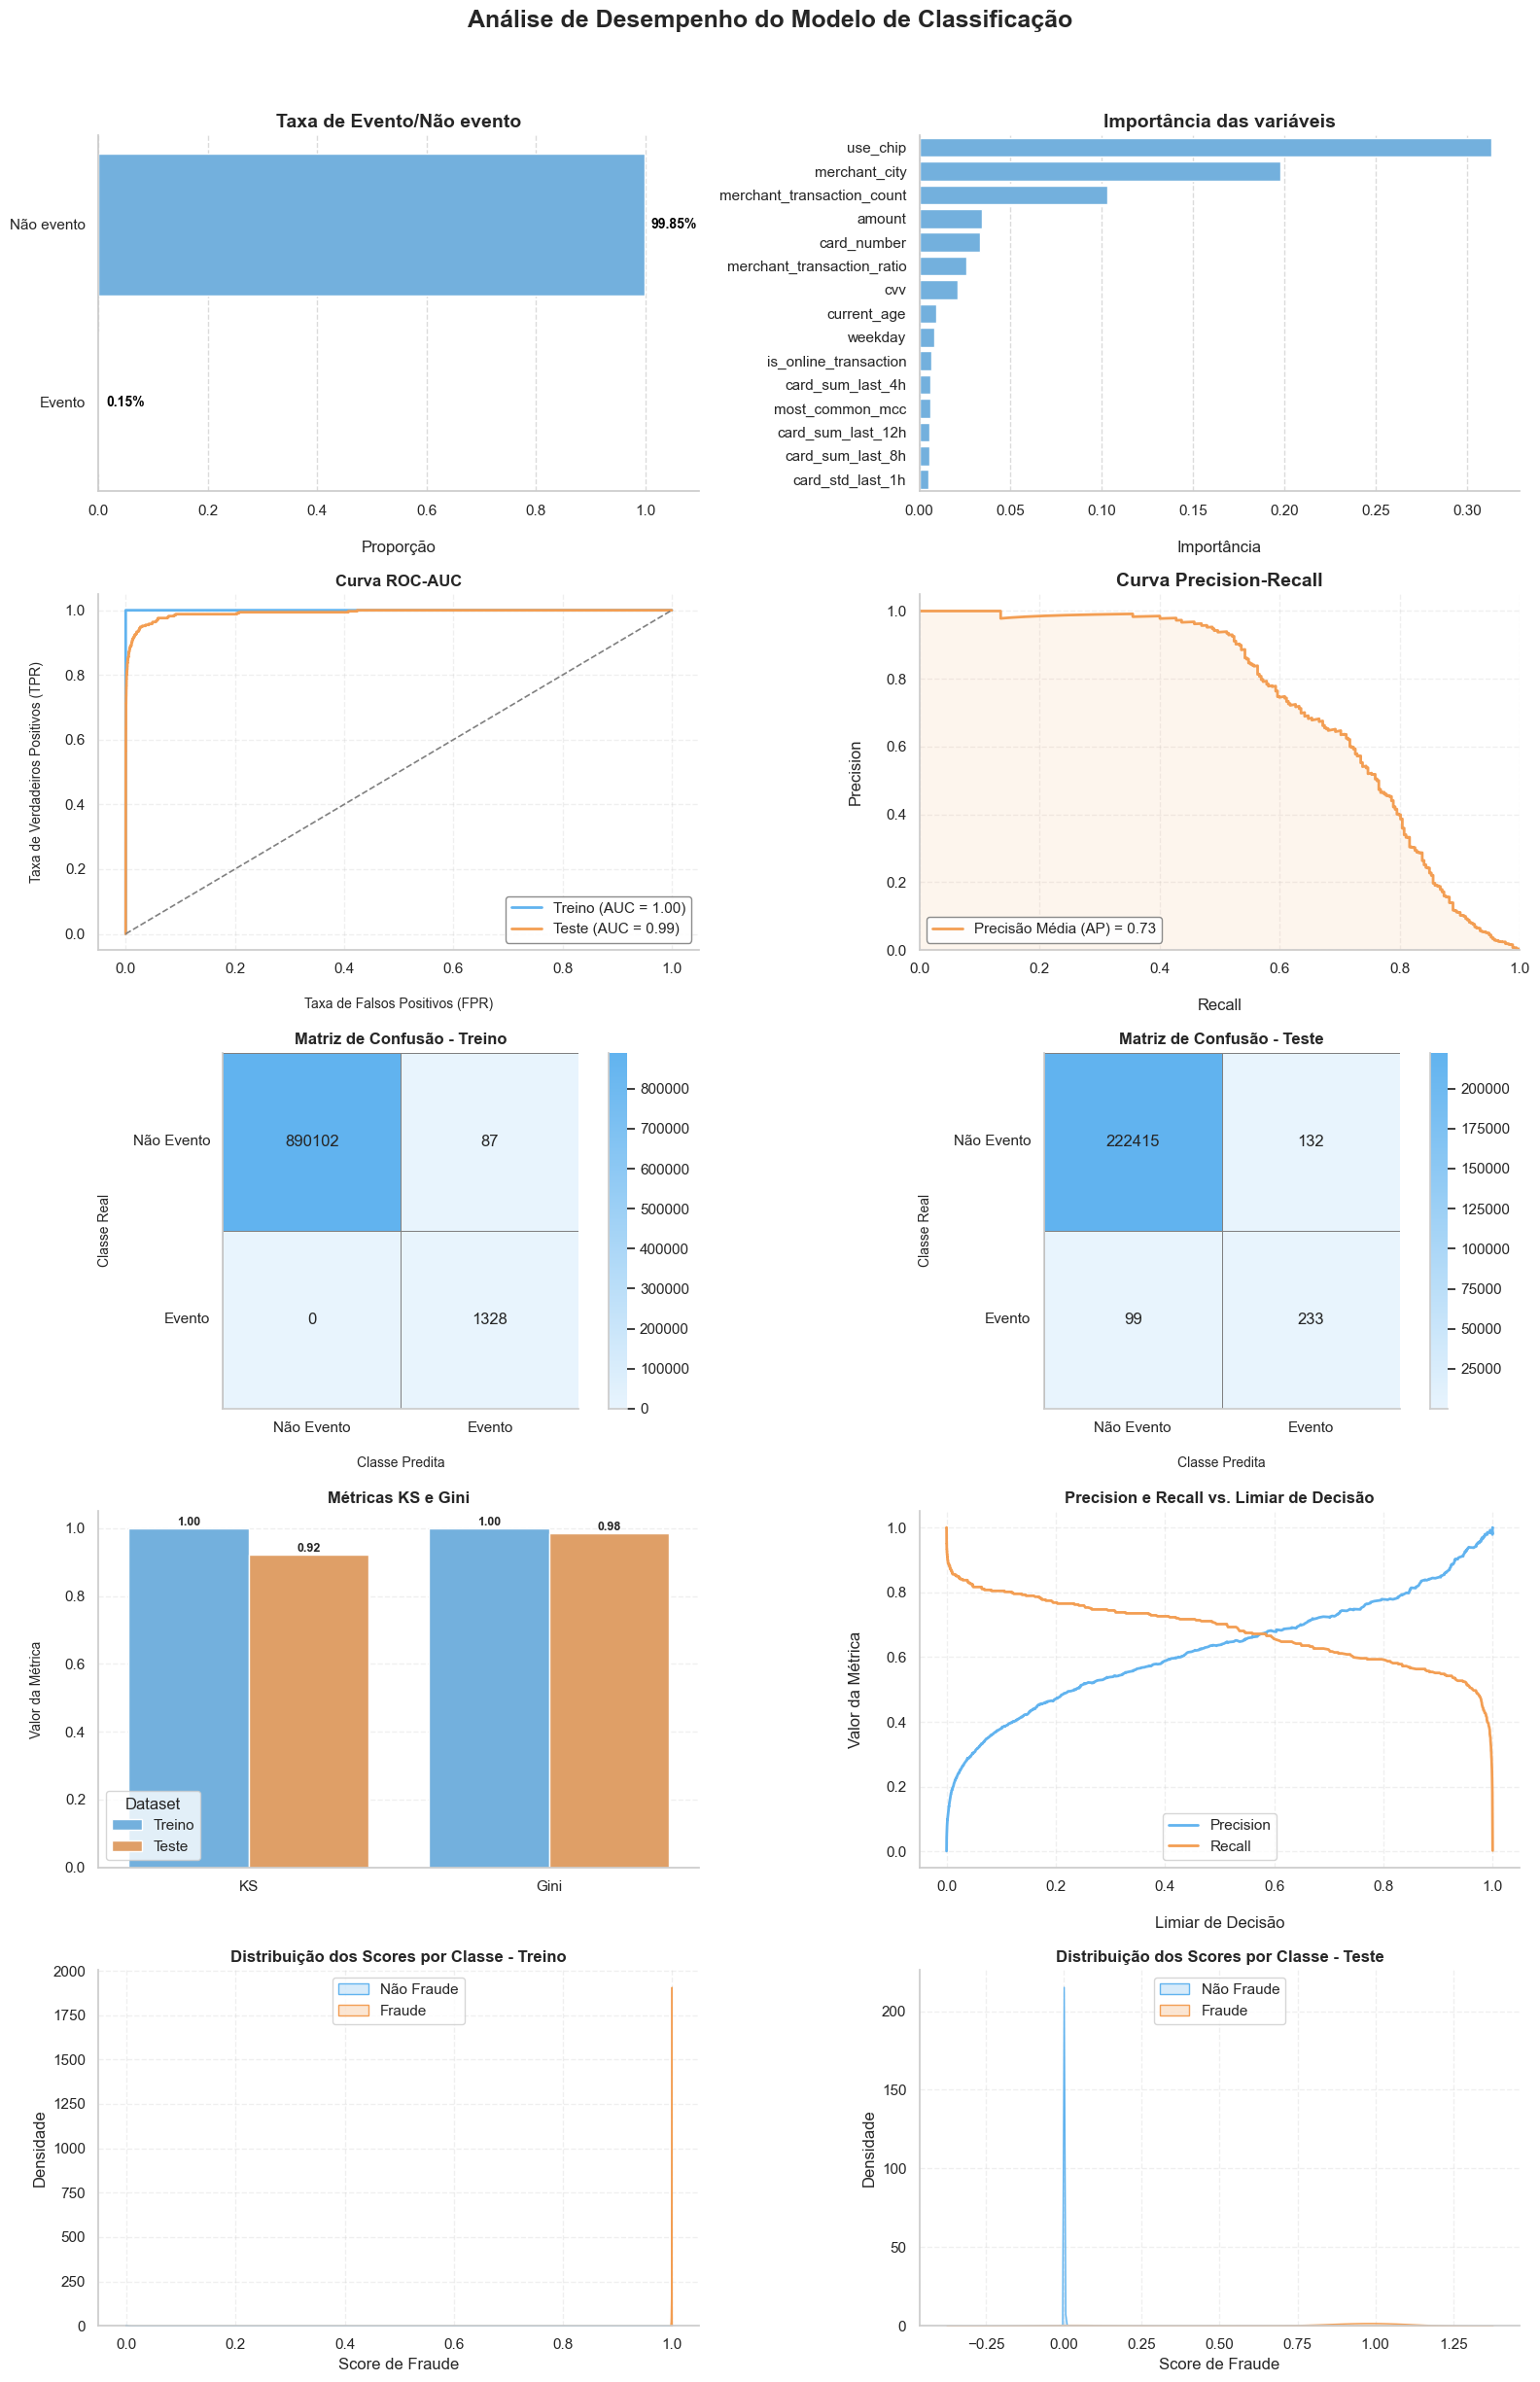

In [37]:
# Recupera os melhores hiperpar√¢metros encontrados pelo Optuna
params = study.best_params

# Obt√©m os nomes das features
features = X_train.columns

# Inicializa o modelo XGBoost com os melhores hiperpar√¢metros ajustados
best_algorithm_tuned = XGBClassifier(**params, random_state=42, scale_pos_weight=scale_pos_weight,
                                      eval_metric='logloss', use_label_encoder=False, 
                                      verbosity=0, n_jobs=-1)

# Treina o modelo com os dados j√° pr√©-processados
best_algorithm_tuned.fit(X_train_processed, y_train)

# Plota as m√©tricas de desempenho do melhor modelo ajustado
plot_metrics(best_algorithm_tuned, X_train_processed, y_train, X_test_processed, y_test, features)

### 5.3. Avalia√ß√£o do modelo com a altera√ß√£o de thresholds

In [38]:
def evaluate_model_thresholds(model, X_test, y_test, limit_min=0.5):
    '''
    Avalia um modelo de classifica√ß√£o em conjunto de dados desbalanceado usando diferentes thresholds.

    :param model: estimador
        Modelo treinado com o m√©todo predict_proba.
    :param X_test: DataFrame 
        Features do conjunto de teste
    :param y_test: np.ndarray
        R√≥tulos verdadeiros do conjunto de teste
    :param limit_min: float, default=0.5
        Valor m√≠nimo a ser garantido para precis√£o ou recall
        
    :return: dict
        Dicion√°rio com as predi√ß√µes: padr√£o, f1, precision custom e recall custom
    '''
    
    # Probabilidades previstas
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Predi√ß√µes com threshold padr√£o de 0.5
    y_pred = model.predict(X_test)

    # M√©tricas no threshold padr√£o
    print('\nüî∂ Relat√≥rio com threshold padr√£o (0.5):\n')
    print(classification_report(y_test, y_pred, zero_division=0, digits=3))
    print(f'ROC AUC: {roc_auc_score(y_test, y_pred_proba):.5f}')
    print(f'PR AUC (Average Precision): {average_precision_score(y_test, y_pred_proba):.5f}')

    # Curva Precision-Recall
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    precision = precision[:-1]      # Remove o √∫ltimo valor para alinhar com os thresholds
    recall = recall[:-1]            # Remove o √∫ltimo valor para alinhar com os thresholds
    thresholds = thresholds[:-1]    # Remove o √∫ltimo valor para alinhar com precision e recall

    # F1-score em cada threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    idx_best_f1 = np.argmax(f1_scores)
    best_f1_threshold = thresholds[idx_best_f1]

    print(f'\nMelhor F1-score na curva PR: {f1_scores[idx_best_f1]:.5f}')
    print(f'Threshold que otimizou o F1-score: {best_f1_threshold:.5f}\n')

    y_pred_best_f1 = (y_pred_proba >= best_f1_threshold).astype(int)
    print(f'üî∂ Relat√≥rio com threshold do melhor F1-score ({best_f1_threshold:.5f}):\n')
    print(classification_report(y_test, y_pred_best_f1, zero_division=0, digits=3))
    print(f'ROC AUC: {roc_auc_score(y_test, y_pred_best_f1):.5f}')
    print(f'PR AUC (Average Precision): {average_precision_score(y_test, y_pred_best_f1):.5f}')

    # Maior recall mantendo precision ‚â• limit_min
    valid_recall = [(t, p, r) for t, p, r in zip(thresholds, precision, recall) if p >= limit_min]
    t_high_recall = max(valid_recall, key=lambda x: x[2], default=(None, None, None))

    # Maior precision mantendo recall ‚â• limit_min
    valid_precision = [(t, p, r) for t, p, r in zip(thresholds, precision, recall) if r >= limit_min]
    t_high_precision = max(valid_precision, key=lambda x: x[1], default=(None, None, None))

    # Relat√≥rios personalizados
    if t_high_precision[0] is not None:
        y_pred_custom_precision = (y_pred_proba >= t_high_precision[0]).astype(int)
        print(f'\nüî∂ Threshold com maior Precision (Recall ‚â• {limit_min}): {t_high_precision[0]:.5f} | Precision: {t_high_precision[1]:.2f} | Recall: {t_high_precision[2]:.2f}\n')
        print(classification_report(y_test, y_pred_custom_precision, zero_division=0, digits=3))
    else:
        print(f'\nüî∫ Nenhum threshold com Recall ‚â• {limit_min} foi encontrado para Precision m√°xima.')

    if t_high_recall[0] is not None:
        y_pred_custom_recall = (y_pred_proba >= t_high_recall[0]).astype(int)
        print(f'\nüî∂ Threshold com maior Recall (Precision ‚â• {limit_min}): {t_high_recall[0]:.5f} | Recall: {t_high_recall[2]:.2f} | Precision: {t_high_recall[1]:.2f}\n')
        print(classification_report(y_test, y_pred_custom_recall, zero_division=0, digits=3))
    else:
        print(f'\nüî∫ Nenhum threshold com Precision ‚â• {limit_min} foi encontrado para Recall m√°ximo.')
        
    return {
        'default': y_pred,
        'f1': y_pred_best_f1,
        'precision': y_pred_custom_precision,
        'recall': y_pred_custom_recall,
        'proba': y_pred_proba,
        'thresholds': {
            'f1': best_f1_threshold,
            'precision': t_high_precision[0],
            'recall': t_high_recall[0]
        }
    }


In [39]:
# Executa a avalia√ß√£o e armazena as predi√ß√µes
results = evaluate_model_thresholds(best_algorithm_tuned, X_test_processed, y_test, limit_min=0.689)


üî∂ Relat√≥rio com threshold padr√£o (0.5):

              precision    recall  f1-score   support

           0      1.000     0.999     0.999    222547
           1      0.638     0.702     0.669       332

    accuracy                          0.999    222879
   macro avg      0.819     0.851     0.834    222879
weighted avg      0.999     0.999     0.999    222879

ROC AUC: 0.99236
PR AUC (Average Precision): 0.72824

Melhor F1-score na curva PR: 0.67387
Threshold que otimizou o F1-score: 0.87646

üî∂ Relat√≥rio com threshold do melhor F1-score (0.87646):

              precision    recall  f1-score   support

           0      0.999     1.000     1.000    222547
           1      0.839     0.563     0.674       332

    accuracy                          0.999    222879
   macro avg      0.919     0.782     0.837    222879
weighted avg      0.999     0.999     0.999    222879

ROC AUC: 0.78155
PR AUC (Average Precision): 0.47297

üî∂ Threshold com maior Precision (Recall ‚â• 0.

In [40]:
def plot_confusion_matrices(y_test, y_pred_default, y_pred_f1, y_pred_precision, y_pred_recall):
    '''
    Plota quatro matrizes de confus√£o comparando diferentes thresholds de decis√£o 
    para um modelo de classifica√ß√£o em um problema desbalanceado.

    :param y_test: np.ndarray
        R√≥tulos verdadeiros do conjunto de teste.
    :param y_pred_default: np.ndarray
        Predi√ß√µes com threshold padr√£o de 0.5.
    :param y_pred_f1: np.ndarray
        Predi√ß√µes com threshold otimizado para o melhor F1-score.
    :param y_pred_precision: np.ndarray
        Predi√ß√µes com threshold ajustado para m√°xima precis√£o com recall ‚â• limite m√≠nimo.
    :param y_pred_recall: np.ndarray
        Predi√ß√µes com threshold ajustado para m√°ximo recall com precis√£o ‚â• limite m√≠nimo.
    '''

    # Paleta de cores personalizada
    cmap_custom = LinearSegmentedColormap.from_list('custom_blues', ['#e8f4fd', '#61b3ef'])

    # Cria√ß√£o da figura com subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    # Lista com as predi√ß√µes e os t√≠tulos dos gr√°ficos
    predicoes = [
        (y_pred_default, 'Threshold padr√£o (0.5)', axs[0, 0]),
        (y_pred_f1, 'Threshold ajustado (F1-score)', axs[0, 1]),
        (y_pred_precision, 'Threshold ajustado (Precision ‚â• limite)', axs[1, 0]),
        (y_pred_recall, 'Threshold ajustado (Recall ‚â• limite)', axs[1, 1])
    ]

    # Loop para desenhar cada matriz de confus√£o
    for y_pred, titulo, ax in predicoes:
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap_custom,
                    annot_kws={'size': 16}, cbar_kws={'label': ''},
                    linewidths=0.5, linecolor='gray', square=True, ax=ax)
        ax.set_title(titulo, fontsize=12, fontweight='bold')
        ax.set_xlabel('\nClasse Predita')
        ax.set_ylabel('Classe Real\n')
        ax.set_xticklabels(['N√£o Evento', 'Evento'])
        ax.set_yticklabels(['N√£o Evento', 'Evento'], rotation=90)

    plt.tight_layout()
    plt.show()


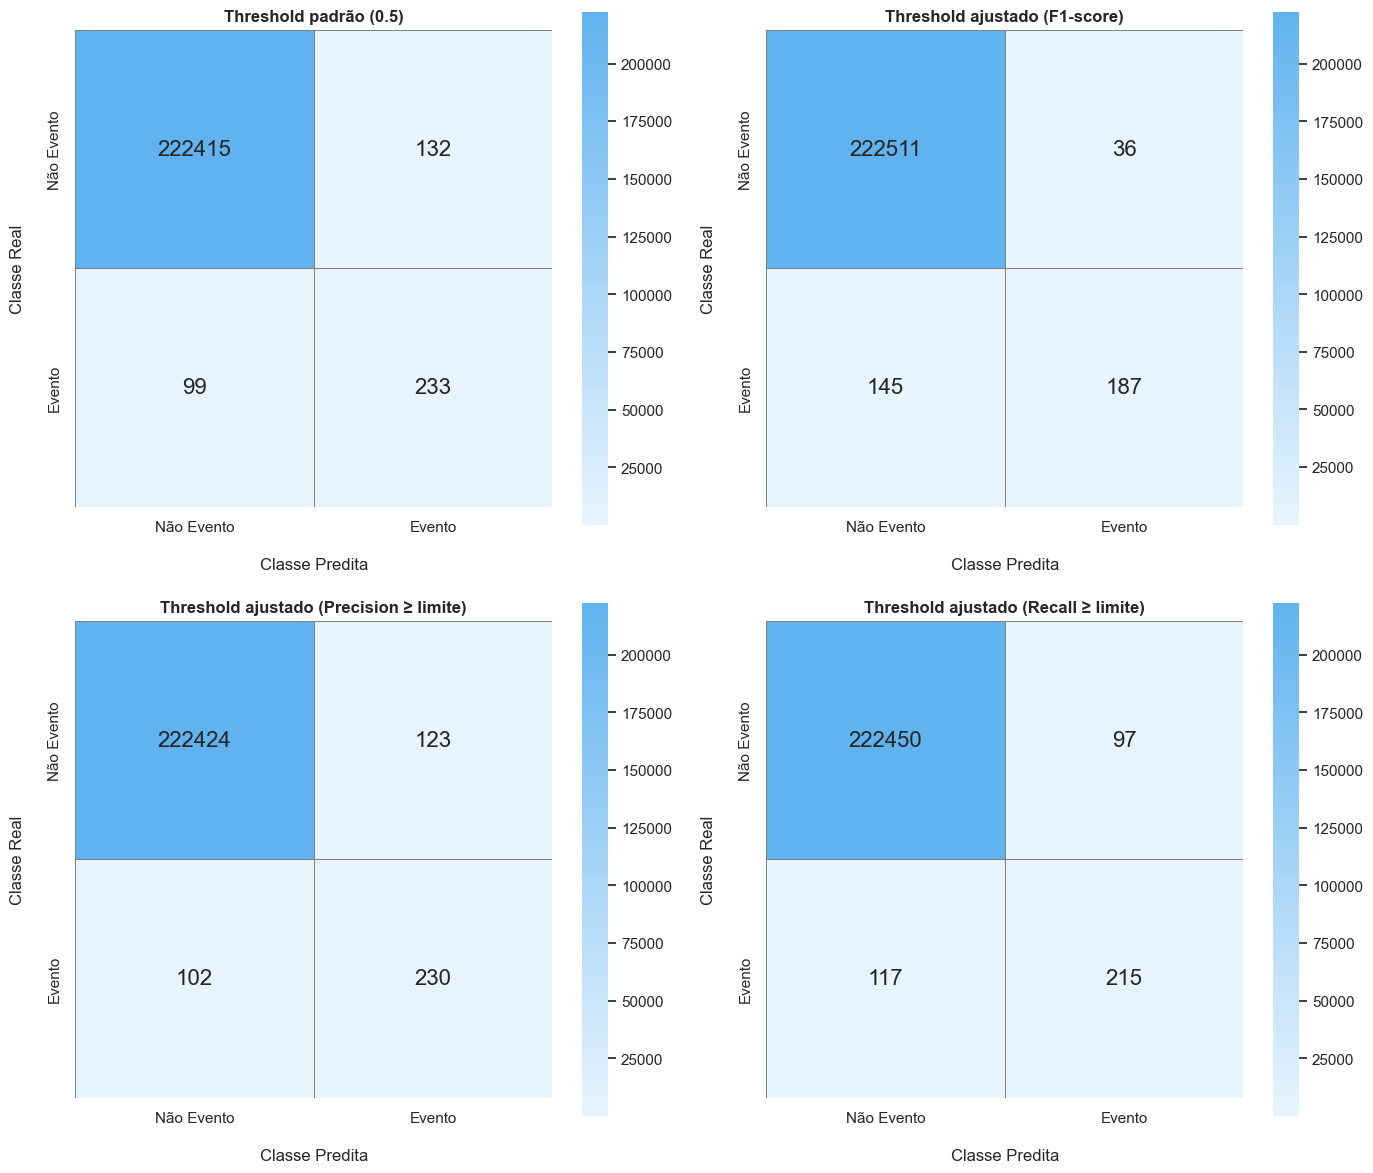

In [41]:
# Passa as predi√ß√µes para a fun√ß√£o de plot
plot_confusion_matrices(y_test, results['default'], results['f1'], results['precision'], results['recall'])

## 6. An√°lise e desempenho do modelo com N vari√°veis

### 6.1. Visualiza√ß√£o das N vari√°veis mais importantes

In [42]:
# Obtendo a import√¢ncia das vari√°veis do modelo ajustado
importances = best_algorithm_tuned.feature_importances_

# Contando a quantidade de vari√°veis que entraram no modelo ajustado
qtd_vars_model = (importances > 0).sum()

print(f'Quantidade de vari√°veis que entraram no modelo ajustado: {qtd_vars_model}')


Quantidade de vari√°veis que entraram no modelo ajustado: 140


In [43]:
def plot_feature_importance(model, features, top_n_features=10):
    '''
    Exibe gr√°fico de import√¢ncia das vari√°veis de um modelo com atributo `feature_importances_`.

    :param model: estimator
        Estimador previamente treinado com o atributo `feature_importances_`.
    :param features: list or array-like
        Lista com os nomes das vari√°veis utilizadas no modelo.
    :param top_n_features: int, default=10
        N√∫mero de vari√°veis mais importantes a serem exibidas no gr√°fico.
    '''

    # Verifica se o modelo possui o atributo necess√°rio
    if not hasattr(model, 'feature_importances_'):
        raise ValueError('O modelo fornecido n√£o possui o atributo `feature_importances_`.')

    # Obt√©m e ordena as import√¢ncias
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n_features]
    
    # Seleciona as top_n_features
    top_features = np.array(features)[indices]
    top_importances = importances[indices]

    # Cria o gr√°fico
    plt.figure(figsize=(12, 6))
    sns.barplot(y=top_features, x=top_importances, palette=['#61b3ef'])

    plt.title(f'Import√¢ncia das {top_n_features} vari√°veis', fontsize=14, fontweight='bold')
    plt.xlabel('\nImport√¢ncia', fontsize=12)
    plt.ylabel('Vari√°vel', fontsize=12)

    # Adiciona os valores num√©ricos ao lado das barras
    for i, v in enumerate(top_importances):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=10)

    sns.despine()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


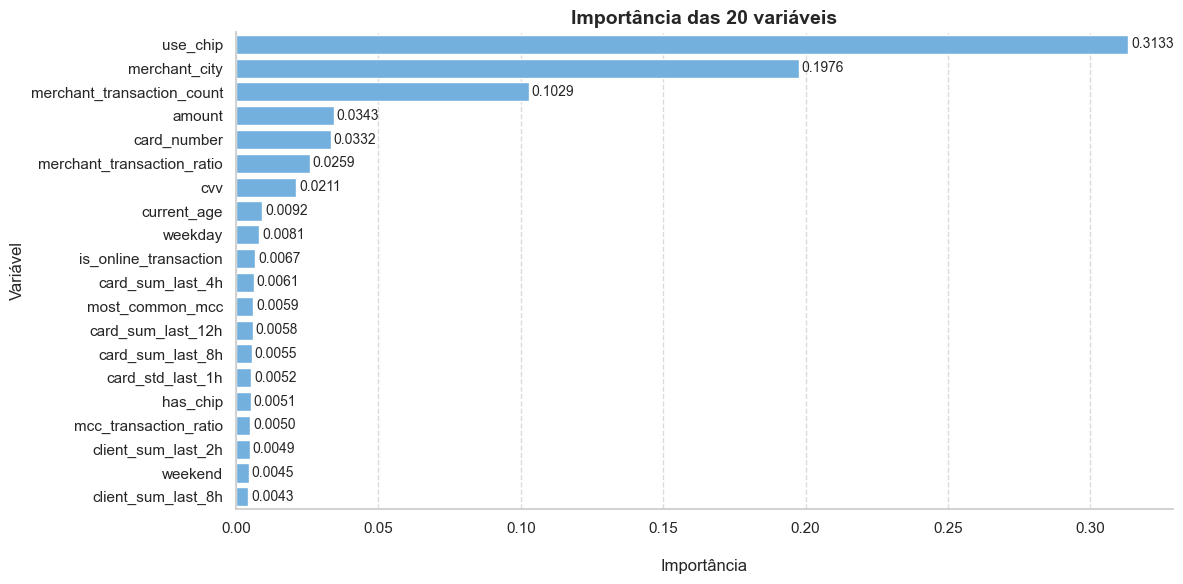

In [44]:
# Exibe o gr√°fico de import√¢ncia das vari√°veis do modelo ajustado
plot_feature_importance(best_algorithm_tuned, features, top_n_features=20)


### 6.2. Avalia√ß√£o do modelo com N vari√°veis mais importantes

In [ ]:
def evaluate_model_summary(model, X_train, y_train, X_test, y_test, feature_names, n_features_list):
    '''
    Avalia o desempenho de um modelo usando as N vari√°veis mais importantes.

    :param model: estimador
        Estimador j√° treinado com suporte a feature_importances_.
    :param X_train: array ou DataFrame
        Dados de treino com todas as features.
    :param y_train: array
        R√≥tulos do treino.
    :param X_test: array ou DataFrame
        Dados de teste com todas as features.
    :param y_test: array
        R√≥tulos do teste.
    :param feature_names: list
        Lista com os nomes das vari√°veis (deve corresponder a X_train.columns).
    :param n_features_list: list
        Lista com os valores de N a testar (ex: [5, 10, 20]).
        
    :return: DataFrame
        Tabela com as m√©tricas de avalia√ß√£o para cada valor de N.
    '''

    resultados = []

    # Verifica se o modelo possui o atributo necess√°rio
    if not hasattr(model, 'feature_importances_'):
        raise ValueError('O modelo fornecido n√£o possui o atributo `feature_importances_`.')

    # Garante que os dados estejam em formato DataFrame com colunas nomeadas
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train, columns=feature_names)
    if not isinstance(X_test, pd.DataFrame):
        X_test = pd.DataFrame(X_test, columns=feature_names)

    # Obt√©m e ordena as import√¢ncias
    importances = model.feature_importances_
    indices_ordenados = np.argsort(importances)[::-1]  # Mais importantes primeiro

    # Loop para testar o modelo com diferentes quantidades de vari√°veis
    for n in n_features_list:
        
        # Seleciona os N nomes das vari√°veis mais importantes
        top_indices = indices_ordenados[:n]
        top_features = np.array(feature_names)[top_indices].tolist()

        # Cria subconjuntos de treino e teste com as N vari√°veis mais importantes
        X_train_subset = X_train[top_features]
        X_test_subset = X_test[top_features]

        # Clona o modelo original e o treina novamente usando apenas as N vari√°veis selecionadas
        modelo_n = model.__class__(**model.get_params())
        modelo_n.fit(X_train_subset, y_train)

        # Score da primeira inst√¢ncia
        start = time.time()
        score_fraude = modelo_n.predict_proba(X_test_subset.iloc[[0]])[:, 1][0]
        tempo_pred = time.time() - start

        # Predi√ß√µes e m√©tricas
        y_pred = modelo_n.predict(X_test_subset)
        y_proba = modelo_n.predict_proba(X_test_subset)[:, 1]

        auc = roc_auc_score(y_test, y_proba)
        gini = 2 * auc - 1
        ks = ks_2samp(y_proba[y_test == 1], y_proba[y_test == 0]).statistic

        resultados.append({
            'Top N features': n,
            'Score fraude': score_fraude,
            'Tempo de predi√ß√£o': tempo_pred,
            'Acur√°cia': accuracy_score(y_test, y_pred),
            'Precis√£o': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred),
            'F1-Score': f1_score(y_test, y_pred),
            'ROC AUC': auc,
            'PR AUC': average_precision_score(y_test, y_proba),
            'KS': ks,
            'Gini': gini
        })

    return pd.DataFrame(resultados)



In [46]:
# Lista de N vari√°veis a serem testadas
n_features_list = [15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 140]

# Avalia o modelo com as N vari√°veis mais importantes
df_results = evaluate_model_summary(
    model=best_algorithm_tuned,
    X_train=X_train_processed,
    y_train=y_train,
    X_test=X_test_processed,
    y_test=y_test,
    feature_names=features,
    n_features_list=n_features_list
)

display(df_results)


Top N features  Score fraude  Tempo de predi√ß√£o  Acur√°cia  Precis√£o  \
0               15      0.000002           0.002992  0.997613  0.345201   
1               20      0.000001           0.001995  0.998165  0.427221   
2               25      0.000002           0.001995  0.998694  0.549878   
3               30      0.000001           0.002157  0.998757  0.570694   
4               35      0.000002           0.002992  0.998703  0.552311   
5               40      0.000001           0.004075  0.998789  0.579897   
6               45      0.000001           0.003989  0.998807  0.585938   
7               50      0.000001           0.003099  0.998676  0.545906   
8               60      0.000001           0.004987  0.998829  0.593668   
9               70      0.000002           0.003989  0.998874  0.607427   
10              80      0.000002           0.005101  0.998964  0.643059   
11              90      0.000002           0.006088  0.998865  0.607629   
12             140      0.000002           0.006981  0.998851  0.601064   

      Recall  F1-Score   ROC AUC    PR AUC        KS      Gini  
0   0.671687  0.456033  0.990960  0.646323  0.907403  0.981920  
1   0.680723  0.524971  0.993829  0.683450  0.922086  0.987657  
2   0.680723  0.608345  0.993262  0.707727  0.923475  0.986524  
3   0.668675  0.615811  0.993636  0.708124  0.920857  0.987272  
4   0.683735  0.611036  0.992516  0.711100  0.917892  0.985031  
5   0.677711  0.625000  0.993873  0.716242  0.919294  0.987746  
6   0.677711  0.628492  0.993235  0.719712  0.925916  0.986471  
7   0.662651  0.598639  0.991778  0.699548  0.917001  0.983555  
8   0.677711  0.632911  0.990842  0.718426  0.915545  0.981685  
9   0.689759  0.645980  0.992280  0.727900  0.921698  0.984560  
10  0.683735  0.662774  0.992446  0.740605  0.917722  0.984891  
11  0.671687  0.638054  0.992722  0.723721  0.913424  0.985443  
12  0.680723  0.638418  0.993509  0.723463  0.922790  0.987019

## 7. Tunagem dos hiperpar√¢metros do modelo com N vari√°veis

### 7.1. Criando o pipeline de pr√©-processamento

In [ ]:
# Define o n√∫mero de vari√°veis mais importantes a serem exibidas
top_n_features = 80

# Obt√©m as import√¢ncias das vari√°veis do modelo ajustado
importances = best_algorithm_tuned.feature_importances_
indices = np.argsort(importances)[::-1][:top_n_features]

# Seleciona as top_n_features e seus nomes
top_features = np.array(features)[indices].tolist()

In [50]:
# Separando as vari√°veis num√©ricas e categ√≥ricas

numerical_top_features = X_train[top_features].select_dtypes(exclude=[object, 'category']).columns
categorical_top_features = X_train[top_features].select_dtypes(include=[object, 'category']).columns

In [51]:
# Criando o pipeline para as vari√°veis num√©ricas
num_pipeline_top_features = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# Criando o pipeline para as vari√°veis categ√≥ricas
cat_pipeline_top_features = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder())
])

In [52]:
# Criando o pipeline de pr√©-processamento que aplica transforma√ß√µes

preprocessor_top_features = ColumnTransformer([
        ('num', num_pipeline_top_features, numerical_top_features),
        ('cat', cat_pipeline_top_features, categorical_top_features)
])
preprocessor_top_features = Pipeline(steps=[('preprocessor', preprocessor_top_features)])

In [47]:
import sys
sys.exit(0)  # Interrompe a execu√ß√£o do script ap√≥s a defini√ß√£o da fun√ß√£o

SystemExit: 0